In [1]:
from google.colab import files
uploaded = files.upload()

image_path= list(uploaded.keys())[0]

Saving WhatsApp Image 2024-07-12 at 9.34.00 PM.jpeg to WhatsApp Image 2024-07-12 at 9.34.00 PM.jpeg


In [2]:
# Install necessary libraries
!pip install opencv-python-headless

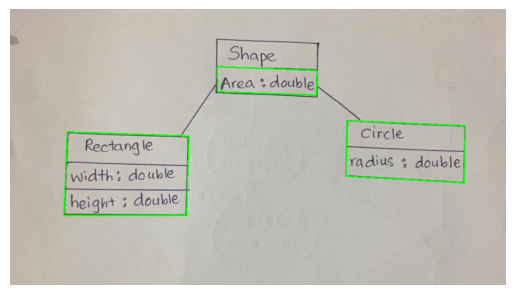

In [3]:


import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_squares(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    squares = []

    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        if len(approx) == 4:
            squares.append(approx)

    # Draw squares on the image
    for square in squares:
        cv2.drawContours(image, [square], -1, (0, 255, 0), 2)

    return image, squares

def display_image(image):
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


detected_image, squares = detect_squares(image_path)
display_image(detected_image)


In [1]:
!pip install google-cloud-vision pillow

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import vision
import io
from google.colab import files
import os

In [3]:
# Step 1: Upload your JSON credentials file
uploaded = files.upload()
credentials_path = list(uploaded.keys())[0]

# Step 2: Set the GOOGLE_APPLICATION_CREDENTIALS environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_path


# Step 3: Initialize Google Cloud Vision API client
client = vision.ImageAnnotatorClient()


Saving final-year-project-428305-b016400d8e0f.json to final-year-project-428305-b016400d8e0f.json


In [11]:
import os
import re
import xml.etree.ElementTree as ET
from PIL import Image
from google.colab import drive

# Import Google Cloud Vision library
from google.cloud import vision

# Mount Google Drive
drive.mount('/content/drive')

def parse_xml_annotation(xml_file):
    if not os.path.exists(xml_file):
        raise FileNotFoundError(f"The file {xml_file} does not exist.")

    try:
        tree = ET.parse(xml_file)
    except ET.ParseError as e:
        raise ValueError(f"Failed to parse XML file {xml_file}: {e}")

    root = tree.getroot()
    annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        annotations.append({
            'class': class_name,
            'bbox': [xmin, ymin, xmax, ymax]
        })

    return annotations

def categorize_annotations(annotations):
    classes = []
    relations = []

    for annotation in annotations:
        if annotation['class'] == 'class':
            classes.append(annotation)
        elif annotation['class'] == 'relation':
            relations.append(annotation)

    return classes, relations

def extract_text_from_image(image_path, bbox):
    image = Image.open(image_path)
    cropped_image = image.crop(bbox)

    # Save the cropped image temporarily
    temp_image_path = "/tmp/temp_image.jpg"
    cropped_image.save(temp_image_path)

    # Read the image file into memory
    with open(temp_image_path, "rb") as image_file:
        content = image_file.read()

    # Use Google Cloud Vision API to detect text
    image = vision.Image(content=content)
    response = client.text_detection(image=image)
    texts = response.text_annotations

    if texts:
        text = texts[0].description.strip()
        # Keep only English letters, numbers, and common punctuation
        text = re.sub(r'[^A-Za-z0-9\s.,-]+', '', text)
        return text
    return ""

def display_class_names_and_relations(classes, relations, image_path):
    class_names = {}
    for cls in classes:
        class_text = extract_text_from_image(image_path, cls['bbox'])
        class_lines = class_text.split('\n')
        if class_lines:
            class_name = class_lines[0]
            class_names[tuple(cls['bbox'])] = class_name
            other_text = "\n".join(class_lines[1:]) if len(class_lines) > 1 else ""
            print(f"Class Name: {class_name}")
            if other_text:
                print(f"Attributes:\n{other_text}\n")

    print("Relations:")
    for relation in relations:
        closest_classes = find_closest_classes(relation['bbox'], classes)
        if len(closest_classes) == 2:
            class_from = class_names.get(tuple(closest_classes[0]['bbox']), 'Unknown')
            class_to = class_names.get(tuple(closest_classes[1]['bbox']), 'Unknown')
            print(f"Relation: {class_from} -> {class_to}")

def find_closest_classes(relation_bbox, classes):
    closest_classes = sorted(classes, key=lambda cls: distance(relation_bbox, cls['bbox']))[:2]
    return closest_classes

def distance(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    a1, b1, a2, b2 = bbox2
    center1 = ((x1 + x2) / 2, (y1 + y2) / 2)
    center2 = ((a1 + a2) / 2, (b1 + b2) / 2)
    return ((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2) ** 0.5

# Path to the XML and image files on Google Drive
# Upload XML and Image files
uploaded = files.upload()
xml_file = list(uploaded.keys())[0]

uploaded = files.upload()
image_file = list(uploaded.keys())[0]

# Debugging: Print current working directory and check file existence
print("Current working directory:", os.getcwd())
print("Trying to access file:", xml_file)
print("File exists:", os.path.exists(xml_file))

annotations = parse_xml_annotation(xml_file)
classes, relations = categorize_annotations(annotations)

display_class_names_and_relations(classes, relations, image_file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving WhatsApp Image 2024-07-12 at 9.34.00 PM.xml to WhatsApp Image 2024-07-12 at 9.34.00 PM (5).xml


Saving WhatsApp Image 2024-07-12 at 9.34.00 PM.jpeg to WhatsApp Image 2024-07-12 at 9.34.00 PM (5).jpeg
Current working directory: /content
Trying to access file: WhatsApp Image 2024-07-12 at 9.34.00 PM (5).xml
File exists: True
Class Name: Shape
Attributes:
Area double

Class Name: Rectangle
Attributes:
Width double
height double

Class Name: Circle
Attributes:
radius double

Relations:
Relation: Shape -> Rectangle
Relation: Circle -> Shape


Saving WhatsApp Image 2024-07-12 at 9.34.00 PM.jpeg to WhatsApp Image 2024-07-12 at 9.34.00 PM (1).jpeg


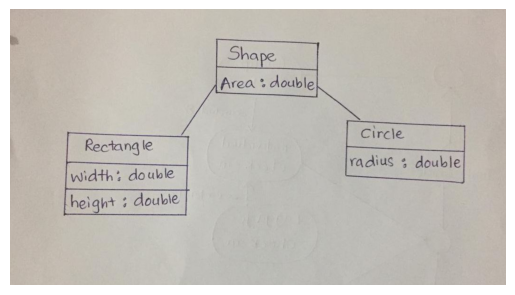

Text in square 1: Rectangle
Width: double
height: double
Text in square 2: Circle
radius double
Text in square 3: Area: double


In [4]:
def detect_squares(image_path):
    # Load the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    squares = []

    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # If the approximated contour has 4 points, it's likely a square
        if len(approx) == 4:
            squares.append(approx)

    return image, squares

def display_image(image):
    # Convert the image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

def crop_and_extract_text(original_image, squares):
    client = vision.ImageAnnotatorClient()

    texts = []
    for square in squares:
        x, y, w, h = cv2.boundingRect(square)
        cropped_image = original_image[y:y+h, x:x+w]

        # Convert to bytes
        _, img_encoded = cv2.imencode('.jpg', cropped_image)
        content = img_encoded.tobytes()

        vision_image = vision.Image(content=content)
        response = client.text_detection(image=vision_image)
        texts.append(response.text_annotations[0].description if response.text_annotations else '')

    return texts

# Upload your class diagram image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Detect squares
image, squares = detect_squares(image_path)
display_image(image)

# Extract text from detected squares
texts = crop_and_extract_text(image, squares)

# Display the extracted texts
for i, text in enumerate(texts):
    print(f"Text in square {i+1}: {text}")